# sarcasm classification

## import libraries

In [1]:
import numpy as np 
import pandas as pd 
import nltk
import json
import os
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_s+
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
#from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [2]:
# punkt divides a text into a list of sentences by using an unsupervised algorithm
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\97150\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
#such as “the”, “a”, “an”, “in” ,English words which does not add much meaning to a sentence
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\97150\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
 data=pd.read_json("Sarcasm_Headlines_Dataset.json" ,lines='true')

In [8]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


# claeaning data

In [9]:
data.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [10]:
del data['article_link']

In [11]:
data.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [12]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text


In [13]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()
    #convert data frame to list 

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove punctuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(data)
head_lines[0:10]

[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  'black',
  'code',
  'minority',
  'shoppers'],
 ['roseanne',
  'revival',
  'catches',
  'thorny',
  'political',
  'mood',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  'sons',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen',
  'come',
  'alternative',
  'debtreduction',
  'ideas'],
 ['jk', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way'],
 ['advancing', 'worlds', 'women'],
 ['fascinating', 'case', 'eating', 'labgrown', 'meat'],
 ['ceo', 'send', 'kids', 'school', 'work', 'company'],
 ['top', 'snake', 'handler', 'leaves', 'sinking', 'huckabee', 'campaign'],
 ['fridays', 'morning', 'email', 'inside', 'trumps', 'presser', 'ages']]

## data visualization 

(-0.5, 999.5, 499.5, -0.5)

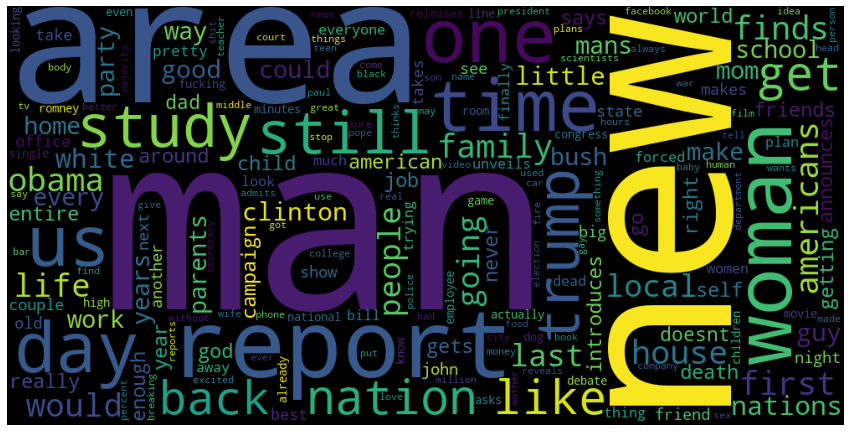

In [14]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

## train , test part 

In [15]:
validation_split = 0.2
max_length = 25

# 25 from eash headline
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values


indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  27483
vocab size - 27484


In [16]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (21368, 25)
Shape of y_train: (21368,)
Shape of X_test_pad: (5341, 25)
Shape of y_test: (5341,)


## GloVe model

In [17]:
embeddings_index = {}
# 100 dimension vector 
embedding_dim = 100
#GLOVE_DIR = "D:\Pre-trained Word Vectors\glove.twitter.27B"
GLOVE_DIR = "C:\\Users\\97150\\Desktop\\glove.twitter.27B"
#"C:\Users\97150\Desktop\glove.twitter.27B"
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.



GloVe = global word of vectors
it allows us to take a corpus of text, and intuitively transform each wordin that corpus into a position in a
high-dimensional space. This means that similar words will be placed together.
مدى اقتراب او ابتعاد الكلمات عن بعض 

## embedding layer

It is an improvement over more the traditional bag-of-word model encoding schemes where large sparse vectors were used to represent each word or to score each word within a vector to represent an entire vocabulary.

In [18]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

23813


In [19]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

## RNN

In [20]:
model = Sequential()
model.add(embedding_layer)
#some hyper parameters  so you can tune to get better result 
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           2748400   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,790,705
Trainable params: 42,305
Non-trainable params: 2,748,400
_________________________________________________________________
None


LSTM stands for long short-term memory networks, used in the field of Deep Learning. It is a variety of recurrent neural networks (RNNs) that are capable of learning long-term dependencies, especially in sequence prediction problems. LSTM has feedback connections, i.e., it is capable of processing the entire sequence of data, apart from single data points such as images. This finds application in speech recognition, machine translation, etc. LSTM is a special kind of RNN, which shows outstanding performance on a large variety of problems

In [21]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/25
668/668 - 9s - loss: 0.5469 - acc: 0.7243 - val_loss: 0.4742 - val_acc: 0.7761 - 9s/epoch - 14ms/step
Epoch 2/25
668/668 - 7s - loss: 0.4734 - acc: 0.7759 - val_loss: 0.4282 - val_acc: 0.7961 - 7s/epoch - 11ms/step
Epoch 3/25
668/668 - 7s - loss: 0.4422 - acc: 0.7915 - val_loss: 0.4129 - val_acc: 0.8087 - 7s/epoch - 11ms/step
Epoch 4/25
668/668 - 8s - loss: 0.4115 - acc: 0.8122 - val_loss: 0.4053 - val_acc: 0.8109 - 8s/epoch - 12ms/step
Epoch 5/25
668/668 - 9s - loss: 0.3961 - acc: 0.8209 - val_loss: 0.4145 - val_acc: 0.8169 - 9s/epoch - 13ms/step
Epoch 6/25
668/668 - 9s - loss: 0.3747 - acc: 0.8372 - val_loss: 0.4001 - val_acc: 0.8204 - 9s/epoch - 13ms/step
Epoch 7/25
668/668 - 9s - loss: 0.3614 - acc: 0.8365 - val_loss: 0.3902 - val_acc: 0.8249 - 9s/epoch - 13ms/step
Epoch 8/25
668/668 - 9s - loss: 0.3500 - acc: 0.8452 - val_loss: 0.4153 - val_acc: 0.8204 - 9s/epoch - 14ms/step
Epoch 9/25
668/668 - 9s - loss: 0.3337 - acc: 0.8557 - val_loss: 0.3796 - val_acc: 0.8341 - 9s/e

##  visualize  

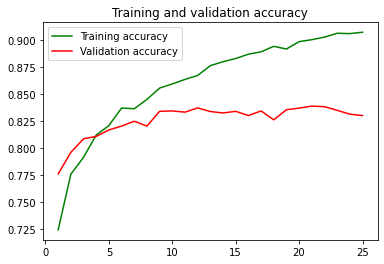

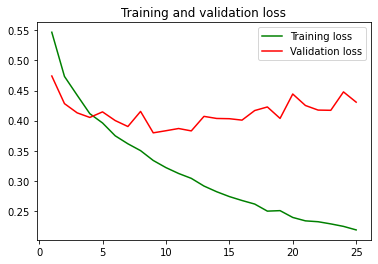

In [22]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## test the model 

In [23]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!" 
    else: return "It's not a sarcasm."

### correct predictions

In [24]:
predict_sarcasm("I was depressed. He asked me to be happy. I am not depressed anymore.")

1/1 [==============================] - 0s 160ms/step


"It's a sarcasm!"

In [25]:
predict_sarcasm("You just broke my car window. Great job.")
#sar

1/1 [==============================] - 0s 18ms/step


"It's a sarcasm!"

In [26]:

predict_sarcasm("You just saved my dog's life. Thanks a million.")


1/1 [==============================] - 0s 16ms/step


"It's not a sarcasm."

In [27]:
predict_sarcasm("he is a fat person")
#sar

1/1 [==============================] - 0s 16ms/step


"It's a sarcasm!"

In [28]:
predict_sarcasm("I walked into my hotel room and wondered if the interior decorators thought orange was the new black")

1/1 [==============================] - 0s 16ms/step


"It's a sarcasm!"

In [29]:
predict_sarcasm("my name is ahmed")

1/1 [==============================] - 0s 16ms/step


"It's not a sarcasm."

### wrong predictions 

In [33]:
predict_sarcasm("")

1/1 [==============================] - 0s 13ms/step


"It's a sarcasm!"

In [30]:
predict_sarcasm("if i had a dollar for every smart thing you say. I’ll be poor")

1/1 [==============================] - 0s 16ms/step


"It's not a sarcasm."